<p style="font-family: Arial; font-size:2.75em;color:purple; font-style:bold"><br>

# Clustering with scikit-learn

<br><br></p>

In this notebook, we will learn how to use K-Means with scikit-learn in Python.

We will use cluster analysis to generate a climate model using minute-definition data. This data set has millions of records. How do we create 12 groups?

NOTE: The data set we will use is in a large CSV file called minute.csv.

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from itertools import cycle, islice
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
import datetime

In [2]:
data = pd.read_csv('./meteo/minuto.csv')

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold">Weather data per minute</p>
<br>
The **minute** weather data set comes from the same source as the daily weather data set we use in the decision tree-based classifier notebook. The main difference between these two data sets is that the minute weather data set contains raw sensor measurements captured at one-minute intervals. The daily weather data set instead contained processed (averaged) data.

As with daily weather data, this data comes from a weather station. The weather station is equipped with sensors that capture weather-related measurements such as air temperature, air pressure, and relative humidity. The data was collected over a three-year period, from September 2011 to September 2014, to ensure that sufficient data is captured for different seasons and weather conditions.

Each row in **minute.csv** contains weather data captured for a one-minute interval. Each row, or sample, consists of the following variables:

* **rowID:** Unique key
* **hpwren_timestamp:** measurement timestamp (*Unit: year-month-day hour:minute:second*)
* **air_pressure:** atmospheric pressure (*Hectopascals*)
* **air_temp:** Air temperature (*Degrees Fahrenheit*)
* **avg_wind_direction:** average wind direction during the minute before the timestamp
* **avg_wind_speed:** average wind speed during the minute before the timestamp (meters per second)
* **max_wind_direction:** Maximum wind direction
* **max_wind_speed:** Maximum wind speed
* **min_wind_direction:** Minimum wind direction
* **min_wind_speed:** Minimum wind speed
* **rain_accumulation:** Rain accumulation at timestamp
* **rain_duration:** rain duration
* **relative_humidity:** relative humidity measured in the timestamp

In [3]:
data.shape

(1587257, 13)

In [4]:
data.head()

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
0,0,2011-09-10 00:00:49,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,NaN,NaN,60.5
1,1,2011-09-10 00:01:49,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,0.0,0.0,39.9
2,2,2011-09-10 00:02:49,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,0.0,0.0,43.0
3,3,2011-09-10 00:03:49,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,0.0,0.0,49.5
4,4,2011-09-10 00:04:49,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,0.0,0.0,58.8


<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Data Sampling<br></p>

We have too many rows in the dataset, we will reduce the amount to 10% <br>

In [5]:
# We will choose 1 of each 10 rows with this module operation.
sampled_df = data[data['rowID'] % 10 == 0]
sampled_df.shape

(158726, 13)

Statistics

In [6]:
#Describing the sample and changing columns to rows and rows to columns so that the description looks better
sampled_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rowID,158726.0,793625.000000,458203.937509,0.00,396812.5,793625.00,1190437.50,1587250.00
air_pressure,158726.0,916.830161,3.051717,905.00,914.8,916.70,918.70,929.50
air_temp,158726.0,61.851589,11.833569,31.64,52.7,62.24,70.88,99.50
avg_wind_direction,158680.0,162.156100,95.278201,0.00,62.0,182.00,217.00,359.00
avg_wind_speed,158680.0,2.775215,2.057624,0.00,1.3,2.20,3.80,31.90
max_wind_direction,158680.0,163.462144,92.452139,0.00,68.0,187.00,223.00,359.00
max_wind_speed,158680.0,3.400558,2.418802,0.10,1.6,2.70,4.60,36.00
min_wind_direction,158680.0,166.774017,97.441109,0.00,76.0,180.00,212.00,359.00
min_wind_speed,158680.0,2.134664,1.742113,0.00,0.8,1.60,3.00,31.60
rain_accumulation,158725.0,0.000318,0.011236,0.00,0.0,0.00,0.00,3.12


In [7]:
#we detect that the rain accumulation and rain duration columns have values of zero
sampled_df[sampled_df['rain_accumulation'] == 0].shape

(157812, 13)

In [8]:
sampled_df[sampled_df['rain_duration'] == 0].shape

(157237, 13)

Cleaning this data

In [9]:
# Since both columns have a lot of zeros, we'll delete them entirely.
del sampled_df['rain_accumulation']
del sampled_df['rain_duration']

In [10]:
rows_before = sampled_df.shape[0]
# Deleting rows with null data
sampled_df = sampled_df.dropna()
rows_after = sampled_df.shape[0]

In [11]:
rows_before - rows_after

46

In [12]:
sampled_df.columns

Index(['rowID', 'hpwren_timestamp', 'air_pressure', 'air_temp',
       'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction',
       'max_wind_speed', 'min_wind_direction', 'min_wind_speed',
       'relative_humidity'],
      dtype='object')

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

We select the qualities of interest to address clustering
<br><br></p>

In [13]:
#These are the columns that we select as features
features = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 
        'max_wind_speed','relative_humidity']

In [14]:
select_df = sampled_df[features]

In [15]:
select_df.columns

Index(['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed',
       'max_wind_direction', 'max_wind_speed', 'relative_humidity'],
      dtype='object')

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Scale the Features using StandardScaler
<br><br></p>


In [16]:
X = StandardScaler().fit_transform(select_df)
X

array([[-1.48456281,  0.24544455, -0.68385323, ..., -0.62153592,
        -0.74440309,  0.49233835],
       [-1.48456281,  0.03247142, -0.19055941, ...,  0.03826701,
        -0.66171726, -0.34710804],
       [-1.51733167,  0.12374562, -0.65236639, ..., -0.44847286,
        -0.37231683,  0.40839371],
       ...,
       [-0.30488381,  1.15818654,  1.90856325, ...,  2.0393087 ,
        -0.70306017,  0.01538018],
       [-0.30488381,  1.12776181,  2.06599745, ..., -1.67073075,
        -0.74440309, -0.04948614],
       [-0.30488381,  1.09733708, -1.63895404, ..., -1.55174989,
        -0.62037434, -0.05711747]])

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Implementating k-Means Clustering
<br><br></p>


In [17]:
#Setting the quantity of clusters we want to have.
kmeans = KMeans(n_clusters=12, n_init = 8)
# Adjusting the model.
model = kmeans.fit(X)
print("model\n", model)

model
 KMeans(n_clusters=12, n_init=8)


<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>


What are the centers of the 12 groups that we formed?
<br><br></p>

In [18]:
centers = model.cluster_centers_
centers

array([[ 0.06232427, -0.78918942, -1.19648758, -0.57053649, -1.04232478,
        -0.58497053,  0.87862509],
       [ 1.36793101, -0.08178749, -1.20690678, -0.04781766, -1.0758316 ,
        -0.0274173 , -0.97793019],
       [-1.17342106, -0.88033233,  0.4455029 ,  1.96796314,  0.53774028,
         1.92909905,  0.91923425],
       [ 0.72921938,  0.44027049,  0.28526707, -0.53492012,  0.47295946,
        -0.54120993, -0.77459466],
       [-0.1628814 ,  0.86265661, -1.31112546, -0.58972161, -1.16687572,
        -0.60502955, -0.64139189],
       [ 0.13028424,  0.84468317,  1.41099664, -0.63856862,  1.67506707,
        -0.58931083, -0.71487071],
       [-0.2115919 ,  0.63070681,  0.40838795,  0.73483868,  0.51650566,
         0.6728548 , -0.1498864 ],
       [-0.84613145, -1.19601634,  0.37491656,  0.33078373,  0.47286312,
         0.31901649,  1.36453764],
       [ 0.2352152 ,  0.32104631,  1.88795452, -0.65170722, -1.5518055 ,
        -0.57656823, -0.28415562],
       [-0.69372662,  0.5421

</br></br>
PLOTS
</br>
First we create some useful functions that will help us plot graphs:

In [19]:
# Function that generates a dataframe with the centers and features used.

def pd_centers(featuresUsed, centers):
	colNames = list(featuresUsed)
	colNames.append('prediction')


	Z = [np.append(A, index) for index, A in enumerate(centers)]

	P = pd.DataFrame(Z, columns=colNames)
	P['prediction'] = P['prediction'].astype(int)
	return P

In [20]:
# Function to create parallel graphs

def parallel_plot(data):
    my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
    plt.style.use("seaborn-dark")
    plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
    parallel_coordinates(data, 'prediction', color = my_colors, marker='o')

In [21]:
P = pd_centers(features, centers)
P

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,prediction
0,0.062324,-0.789189,-1.196488,-0.570536,-1.042325,-0.584971,0.878625,0
1,1.367931,-0.081787,-1.206907,-0.047818,-1.075832,-0.027417,-0.977930,1
2,-1.173421,-0.880332,0.445503,1.967963,0.537740,1.929099,0.919234,2
3,0.729219,0.440270,0.285267,-0.534920,0.472959,-0.541210,-0.774595,3
4,-0.162881,0.862657,-1.311125,-0.589722,-1.166876,-0.605030,-0.641392,4
5,0.130284,0.844683,1.410997,-0.638569,1.675067,-0.589311,-0.714871,5
6,-0.211592,0.630707,0.408388,0.734839,0.516506,0.672855,-0.149886,6
7,-0.846131,-1.196016,0.374917,0.330784,0.472863,0.319016,1.364538,7
8,0.235215,0.321046,1.887955,-0.651707,-1.551806,-0.576568,-0.284156,8
9,-0.693727,0.542146,0.176976,-0.584952,0.346446,-0.598377,-0.113261,9


# Dry Days

C:\Users\DAW2\AppData\Local\Temp\ipykernel_13300\820155285.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-dark")


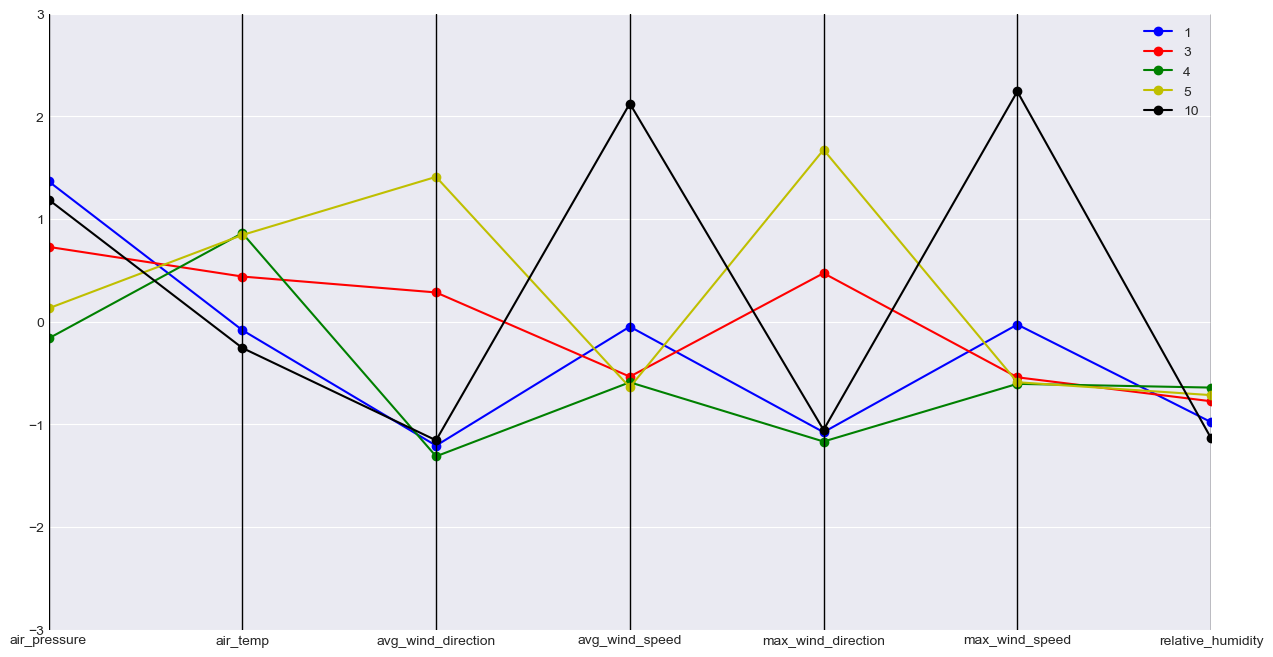

In [22]:
parallel_plot(P[P['relative_humidity'] < -0.5])

# Warm Days

C:\Users\DAW2\AppData\Local\Temp\ipykernel_13300\820155285.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-dark")


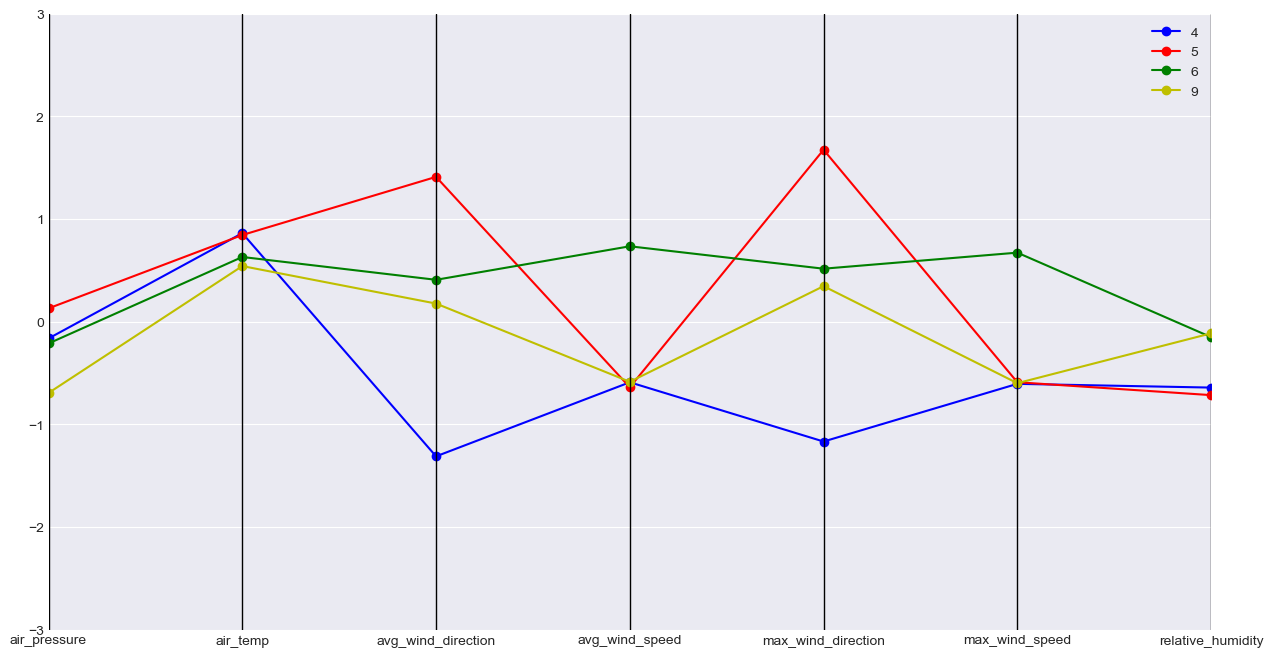

In [23]:
parallel_plot(P[P['air_temp'] > 0.5])

# Cool Days

C:\Users\DAW2\AppData\Local\Temp\ipykernel_13300\820155285.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-dark")


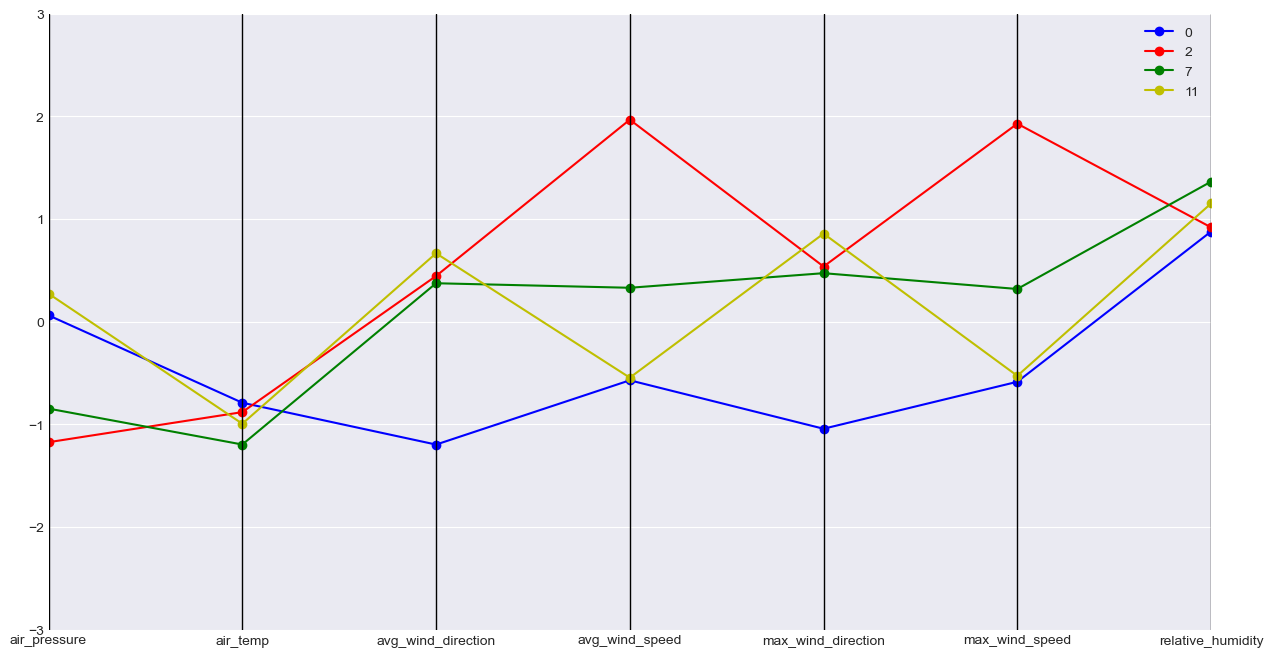

In [24]:
parallel_plot(P[(P['relative_humidity'] > 0.5) & (P['air_temp'] < 0.5)])